# More on $\chi^2$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import fmin, minimize
%matplotlib inline

Suppose we have a linear function,
\begin{equation}
f(x,m,b)=mx+b,
\end{equation}
that we have measured at various $x_i$'s.  Our measurements are noisy, so for each measurement, $y_i$, 
we get a sample of the function $f(x_i,m,b)$ with added noise, $n_i$:
\begin{equation}
y_i=f(x_i,m,b)+n_i,
\end{equation}
Let us assume the noise is drawn from a Gaussian distribution and each measurement has statistically identical noise with variance $\langle n_i^2\rangle\equiv\sigma^2$. 

In [3]:
def f(x, m, b):
    return m*x+b

xs = np.array([-2, -1, 0, 1, 2], dtype=float)
ys = np.array([-4.0761021 , -0.61376301,  0.96543424,  3.7373177 ,  3.86467818])

So given the measurements, `ys`, at the coordinates specified in `xs`, what is your best guess for ($m$,$b$)?
- (1,1)
- (2,1)
- (1,2)
- (2,2)

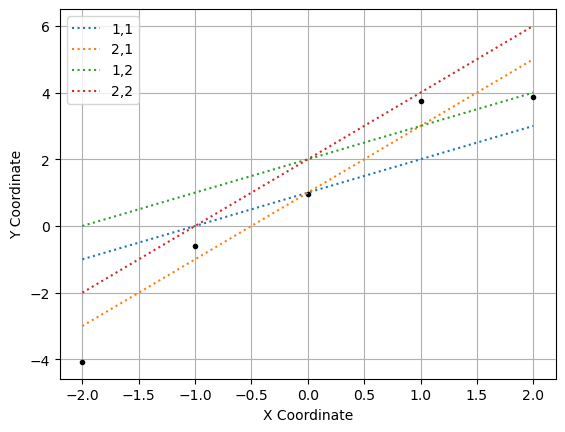

In [4]:
plt.figure()
plt.plot(xs, ys, 'k.')
for m, b in [(1,1), (2,1), (1,2), (2,2)]:
    plt.plot(xs, m * xs + b, ':', label=f'{m},{b}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid()

With a menu of choices, you can directly evaluate $\chi^2$ for each one:
\begin{equation}
\chi^2=\sum_i{\frac{|y_i-f(x_i,\mathbf{p})|^2}{\sigma_i^2}}.
\end{equation}
In the above equation, $i$ indexes different measurements, $\sigma_i$ is the expected error in each measurment, and we have introduced a vector, $\vec p$, that contains the parameters we are fitting.  In the above example, $\mathbf{p} = (m, b)$.

In [5]:
def chisq(ys, mdl, sig):
    return np.sum(np.abs(ys-mdl)**2 / sig**2)

sig = 1. # Let's assume \sigma_i^2=1 for now
ps = [(1,1), (2,1), (1,2), (2,2)]
X2 = [chisq(ys, f(xs,*p), sig) for p in ps]
print('Chi-Square:', np.around(X2,2))

Chi-Square: [13.61  3.14 20.85 10.39]


So it appears $(m,b)=(2,1)$ is the best answer! Here's what it looks like.

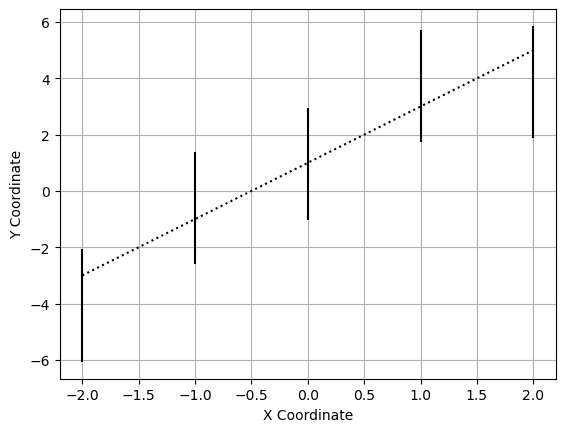

In [8]:
plt.figure()
plt.errorbar(xs,ys,yerr=2, color='k', linestyle='')
plt.plot(xs, 2*xs+1, 'k:')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid()

But what happens if we don't have a menu of choices?  Our options are:
- make our own menu (e.g. sample a grid at some resolution), or
- optimize!

It's time to take a trip down the rabbit-hole of optimizing function.

### Minimizing Functions

If we iterate along, computing gradients, stepping downhill, and recomputing, we can eventually find where (or if) the function's gradient goes to zero, indicating we've minimized it.  However, there is something of an art to taking steps of the right size such that:
- you don't spend forever getting there, but
- you don't overstep, go unstable, and end up at infinity.

In [14]:
def chisq_min(p):
    m, b = p
    return chisq(ys, f(xs, m, b), 1.) 

ans = scipy.optimize.fmin(chisq_min, np.array([0.5, 0.5]))
print('m, b =', np.around(ans, 2))

Optimization terminated successfully.
         Current function value: 2.883578
         Iterations: 35
         Function evaluations: 67
m, b = [2.02 0.78]


So we've gone and fit `m` and `b` in our `f(x) = m*x+b` example, and now we have an answer.  Is this the actual answer?  What are the statistical errors on these measurements?

And if you were wondering, the above is what `np.polyfit` does, except it's programmed in the gradients analytically, so it converges faster.

In [18]:
m, b = np.polyfit(xs, ys, deg=1)
print('m, b =', m, b)

m, b = 2.0232641270000005 0.7755130020000001


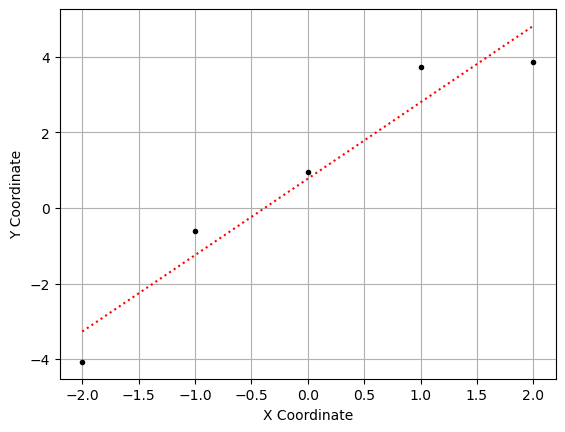

In [16]:
plt.figure()
plt.plot(xs, ys,'k.')
plt.plot(xs, ans[0] * xs + ans[1], 'r:')
plt.grid()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

## Estimating Errors

In the above example, it looks like the final $\chi^2$ of our fit was 2.8.  Is this good?
- Yes
- No
- Maybe
- Depends

So the way we've been writing $\chi^2$, it scales with the number of measurements we make:
\begin{equation}
\chi^2=\sum_i{\frac{|y_i-f(\mathbf c_i,\mathbf p)|^2}{\sigma_i^2}}
\end{equation}

To make a fair comparison, we need to normalize this to the error we expect in a "perfect" fit.  Suppose we knew $m,b$ perfectly, so that we could subtract $f(x_i,m,b)$ from our measurement $y_i=f(x_i,m,b)+n_i$.  In this case, the residual would be $n_i$, and $\langle|n_i|^2\rangle=\sigma_i^2$.  If we know our $\sigma^2$ well, we can construct a *reduced* $\chi^2$,
\begin{equation}
\chi_r^2=\frac{1}{N}\sum_i{\frac{|y_i-f(\mathbf c_i,\mathbf p)|^2}{\sigma_i^2}},
\end{equation}
where we expect $\chi_r^2\approx1$ if we know $\sigma_i$ well enough.

So above, we had $N=5$ measurements, to $\chi_r^2=\chi^2/5=0.58$.  That's a good fit.  Perhaps too good?

## When Fits are "Too Good to be True"

Suppose I have a silly line, $y=0$, and I add some noise to a bunch of measurements of this line, and then fit a line to those measurements and ask for my reduced $\chi^2$ with perfect knowledge of my noise statistics?

In [19]:
chisq_r = []
for i in range(10000):
    ys = np.random.normal(scale=1., size=10)
    xs = np.arange(ys.size) # invent a dummy x variable
    m, b = np.polyfit(xs, ys, deg=1)
    chisq_r.append(np.sum(np.abs(ys - np.polyval([m,b], xs))**2) / ys.size)
print(f'Chi_r^2 = {np.average(chisq_r)}')

Chi_r^2 = 0.7919648174878927


Why is $\chi_r^2<1$?
- The line ate the noise
- Need better noise model
- There wasn't actually a line
- Dividing by wrong number of measurements

As a hint, here's the same code, fitting a 4th order (5 parameter) polynomial:

In [20]:
chisq_r = []
for i in range(10000):
    ys = np.random.normal(scale=1., size=10)
    xs = np.arange(ys.size) # invent a dummy x variable
    poly = np.polyfit(xs, ys, deg=4)
    chisq_r.append(np.sum(np.abs(ys - np.polyval(poly, xs))**2) / ys.size)
print(f'Chi_r^2 = {np.average(chisq_r)}')

Chi_r^2 = 0.5026061436483126


It turns out the degrees of freedom in your model give it enough wiggle room to absorb noise.  Think if it this way: if I fit a line to 2 noisy points, I'll get a perfect fit ($\chi^2=0$), but that doesn't mean that my answer is perfect.

In fact, for every degree of freedom in our model, we can absorb out a degree of freedom in our data.  That means that when we thought we had 10 independent measurements, we actually only had 8 (or 5 in the `deg=4` case).  To account for this, the *real* definition of the reduced $\chi^2$ is:
\begin{equation}
\chi_r^2=\frac{1}{N-M}\sum_i{\frac{|y_i-f(\mathbf x_i,\mathbf p)|^2}{\sigma_i^2}},
\end{equation}
where $M$ is the number of degrees of freedom in the model.  Those degrees of freedom absorb out noise in the data that will then not contribute to the $\chi^2$.  These degrees of freedom also mean that your model is not as over-constrained as you might otherwise think.  To do good science, we want our model to be highly over-constrained, so that errors beat down as $\sqrt{N-M}$.

In [21]:
chisq_r = []
for i in range(10000):
    ys = np.random.normal(scale=1., size=10)
    xs = np.arange(ys.size) # invent a dummy x variable
    poly = np.polyfit(xs, ys, deg=4)
    chisq_r.append(np.sum(np.abs(ys - np.polyval(poly, xs))**2) / (ys.size - len(poly)))
print(f'Chi_r^2 = {np.average(chisq_r)}')

Chi_r^2 = 1.0007020292774755


## Propagating $\chi^2$ to Parameter Errors

The final step here is to use our $\chi^2$ to estimate the errors on our parameters.  Why is there error in our parameters?  Well, remember when we said that the degrees of freedom in our model absorbed out some of the noise?

That's how.

How much did it absorb?  Apparently the difference between $N$ and $N-M$.  A "perfect" fit should have had a (non-reduced) $\chi^2$ that was $M$ higher. That means our $\chi^2$ (again, *not* reduced) should be allowed to increase by 1 for each parameter we fit to get 1$\sigma$ error bars (because $\chi^2$ is in units of $\sigma$).
We change $\mathbf p$ until $\chi^2$ increases by 1 (for 1$\sigma$ error bars), 4 (for 2$\sigma$ error bars), or 9 (for 3$\sigma$ error bars).  

In [26]:
xs = np.array([-2, -1, 0, 1, 2], dtype=float)
ys = np.array([-4.0761021 , -0.61376301,  0.96543424,  3.7373177 ,  3.86467818])

def chisq_min(p):
    m,b = p
    return chisq(ys, f(xs, m, b), 1.)

chi0 = chisq_min(ans)
print('Delta X^2 =', chisq_min(ans+np.array([0.32,0])) - chi0)
print('Delta X^2 =', chisq_min(ans+np.array([-0.32,0])) - chi0)
print('Delta X^2 =', chisq_min(ans+np.array([0,0.45])) - chi0)
print('Delta X^2 =', chisq_min(ans+np.array([0,-0.45])) - chi0)

Delta X^2 = 1.0237900858322155
Delta X^2 = 1.0242099141677845
Delta X^2 = 1.0124092932583366
Delta X^2 = 1.0125907067416637


In [27]:
print(f'm = {ans[0]} +/- 0.32')
print(f'b = {ans[1]} +/- 0.45')

m = 2.023231327911284 +/- 0.32
b = 0.775492844946297 +/- 0.45
